In [29]:
import sqlite3 as lite
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import unicodedata
import re
# import pickle
import time
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns
nltk.downloader.download('vader_lexicon')
nltk.downloader.download('punkt')

import xgboost as xgb
import yahooquery as yq

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Import the 10-K Data from the Database
db_name = "SEC_Filings.db"
table_name = "10K_Data"

engine = sqlalchemy.create_engine('sqlite:///' + db_name, execution_options={"sqlite_raw_colnames": True})
df = pd.read_sql_table(table_name, engine)

# Clean DataFrame
agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df['Industry'] = ''
df.loc[df['SIC'].isin(agri), 'Industry'] = "Agriculture"
df.loc[df['SIC'].isin(fin), 'Industry'] = "Financial Services"
df.loc[df['SIC'].isin(air), 'Industry'] = "Aviation"
df.loc[df['SIC'].isin(bank), 'Industry'] = "Banking"

df = df.drop(['Filing_Link', 'Accession_No', 'SIC', 'Company'], axis=1)

In [50]:
# Sentiment Analysis
# Set 'Aspect' Words
word_search_list_2 = [{'artificial intelligence': ['artificial intelligence', 'artificial-intelligence', ' ai.', ' ai,', ' ai ']},
                      {'deep learning': ['deep learning', 'deep-learning']}, 
                      {'computer vision': ['computer vision', 'computer-vision']}, 
                      'bots', 
                      'automation', 
                      {'machine learning': ['machine learning', 'machine-learning']},
                      'algorithm']
# aspects = [list(x.values())[0] if isinstance (x, dict) else x for x in word_search_list_2]

# Convert 10-K Text to String
# review_text = df['Filing_Document_Text'][0]

# State Sentiment Analyzer - Rule-based Approach
sia = SentimentIntensityAnalyzer()

# Create DataFrame to Store Output
df_sentiments = pd.DataFrame(columns=['Industry', 'Year', 'Aspect', 'Count', 'Sentiment'])

df['Filing_Date'] = pd.to_datetime(df['Filing_Date'], format='%Y-%m-%d')
# Perform Sentiment Analysis

out_list = []
for i, review_text in enumerate(df['Filing_Document_Text']):

    # Create Dictionary to Store Sentiment Scores
    aspect_sentiments = {}
    for aspect_item in word_search_list_2:
        if isinstance(aspect_item, dict):
            aspect = list(aspect_item.keys())[0]
            aspect_sentiments[aspect] = {'count': 0, 'sentiment': 0}
        else:
            aspect_sentiments[aspect_item] = {'count': 0, 'sentiment': 0}

    year = df.loc[i,'Filing_Date'].year
    industry = df.loc[i,'Industry']
    
    sentences = sent_tokenize(review_text)
    for sentence in sentences:
        for aspect_item in word_search_list_2:
            if isinstance (aspect_item, dict):
                aspect = list(aspect_item.keys())[0]
                keywords = list(aspect_item.values())[0]
                for keyword in keywords:
                    if keyword in sentence.lower():
                        sent_score = sia.polarity_scores(sentence)
                        aspect_sentiments[aspect]['count'] += 1
                        aspect_sentiments[aspect]['sentiment'] += sent_score['compound']
            else:
                aspect = aspect_item
                if aspect in sentence.lower():
                    sent_score = sia.polarity_scores(sentence)
                    aspect_sentiments[aspect]['count'] += 1
                    aspect_sentiments[aspect]['sentiment'] += sent_score['compound']
    
    for aspect in aspect_sentiments:
        count = aspect_sentiments[aspect]['count']
        sent = aspect_sentiments[aspect]['sentiment']
        out_data = {'Industry': industry, 'Year': year, 'Aspect': aspect, 'Count': count, 'Sentiment': sent}
        out_list.append(out_data)

df_sentiments = pd.DataFrame.from_dict(out_list)

In [109]:
pd.set_option('display.max_rows', None)

df_agg = df_sentiments[['Industry', 'Aspect', 'Year', 'Count', 'Sentiment']].groupby(['Industry', 'Aspect', 'Year']).sum()
df_agg['Aggregated Sentiment'] = 0
df_agg.loc[df_agg['Count']!=0, 'Aggregated Sentiment'] = df_agg['Sentiment']/df_agg['Count']
df_agg.reset_index(drop=False, inplace=True)
df_agg.drop('Sentiment', axis=1, inplace=True)

df_agg = df_agg.loc[~df_agg['Aspect'].isin(['computer vision', 'deep learning'])].reset_index(drop=True)
df_agg=df_agg.loc[df_agg['Count'] > 5].reset_index(drop=True)

industry_counts = df_sentiments[['Industry', 'Year']].groupby('Industry').count()/len(word_search_list_2)
for industry in df_agg['Industry'].unique():
    df_agg.loc[df_agg['Industry']==industry, 'Average Mentions'] = df_agg['Count']/industry_counts.loc[industry].values

In [7]:
df_agg.to_sql("Aggregated_Sentiment_Scores", engine, if_exists='replace', index=False)

NameError: name 'df_agg' is not defined

In [71]:
cmap = mpl.cm.get_cmap(name='tab10', lut = 9)
col_list = [1, 2, 5, -1] 
colors_hex = [mpl.colors.to_hex(col) for col in cmap.colors[col_list]]
cmap
colors_hex = ['#00da3c', '#0031da', '#da009e', '#daa900']

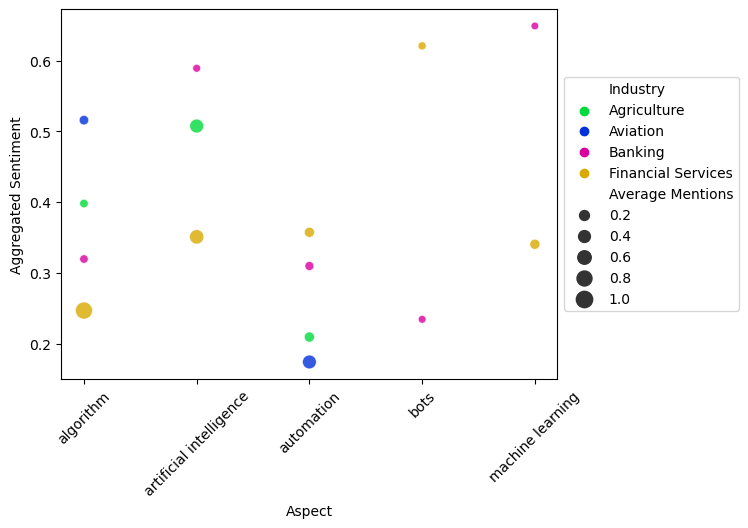

In [101]:
ax = sns.scatterplot(data=df_agg, x="Aspect", y="Aggregated Sentiment", size="Average Mentions", 
                palette=colors_hex, hue="Industry", legend=True, sizes=(30, 150), alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.show()

In [91]:
engine = sqlalchemy.create_engine('sqlite:///' + "SEC_Filings.db", execution_options={"sqlite_raw_colnames": True})
df_ticker = pd.read_sql_table('Ticker_Table', engine)
df_fin_bal = pd.DataFrame()
df_fin_inc = pd.DataFrame()
bal_vars = ['asOfDate', 'CashAndCashEquivalents','TotalAssets','TotalDebt','TangibleBookValue','TotalCapitalization']
inc_vars = ['asOfDate', 'BasicEPS']
# bal_sheet_error = []
bal_sheet_error_tickers = []
inc_stat_error_tickers = []

for ticker in df_ticker['Ticker']:
    tick = yq.Ticker(ticker)
    df_bal_tick = tick.balance_sheet(frequency='a', trailing=False)
    df_inc_tick = tick.income_statement(frequency='a', trailing=False)

    try:
        df_bal_tick = df_bal_tick[bal_vars]
        df_fin_bal = pd.concat([df_fin_bal, df_bal_tick], axis=0)

    except:
        if type(df_bal_tick) == pd.DataFrame:
            # bal_sheet_error.append(f'{ticker}: Missing columns {[var for var in bal_vars if var not in df_bal.columns]}')
            bal_sheet_error_tickers.append(ticker)
        else:
            # bal_sheet_error.append(f'{ticker} Balance sheet not Available')
            bal_sheet_error_tickers.append(ticker)

    try:
        df_inc_tick = df_inc_tick[inc_vars]
        df_fin_inc = pd.concat([df_fin_inc, df_inc_tick], axis=0)

    except:
        if type(df_inc_tick) == pd.DataFrame:
            # print([var for var in inc_vars if var not in df_inc.columns])
            inc_stat_error_tickers.append(ticker)
        else:
            inc_stat_error_tickers.append(ticker)
            
df_fin_bal.reset_index(drop=False, inplace=True)
df_fin_inc.reset_index(drop=False, inplace=True)

         asOfDate  CashAndCashEquivalents   TotalAssets  TotalDebt  \
symbol                                                               
ESQ    2019-12-31              61806000.0  7.980080e+08    86000.0   
ESQ    2020-12-31              65185000.0  9.367140e+08    49000.0   
ESQ    2021-12-31             149156000.0  1.178770e+09        NaN   
ESQ    2022-12-31             164122000.0  1.395639e+09        NaN   

        TangibleBookValue  TotalCapitalization  
symbol                                          
ESQ           111062000.0          111148000.0  
ESQ           126076000.0          126125000.0  
ESQ           143735000.0                  NaN  
ESQ           158158000.0                  NaN  
         asOfDate  CashAndCashEquivalents   TotalAssets    TotalDebt  \
symbol                                                                 
PGC    2019-12-31             208083000.0  5.182879e+09  336538000.0   
PGC    2020-12-31             653220000.0  5.890442e+09  390370000.0 

In [144]:
df_fin_joined = df_fin_inc.merge(df_fin_bal, how='inner', on=['symbol', 'asOfDate'])

In [147]:
conn = lite.connect('Financial.db')
conn.close()

df_fin_cleaned = pd.DataFrame()
# backfill missing values based on company
for ticker in df_fin_joined['symbol'].unique():
    df_fin_cleaned = pd.concat([df_fin_cleaned, df_fin_joined.loc[df_fin_joined['symbol']==ticker].sort_values(
                        by='asOfDate', ascending=True).fillna(method='ffill')])

# Remove rows with incomplete data
missing_ticks = df_fin_cleaned[df_fin_cleaned.isnull().any(axis=1)]['symbol'].unique()
df_fin_cleaned = df_fin_cleaned.loc[~df_fin_cleaned['symbol'].isin(missing_ticks)].reset_index(drop=True)

engine_fin = sqlalchemy.create_engine('sqlite:///' + 'Financial.db', execution_options={"sqlite_raw_colnames": True})
df_fin_cleaned.to_sql("FinancialDataJoined", engine_fin, if_exists='replace', index=False)

1608

In [ ]:
model = xgb.XGBRegressor()